# Driver Drowsiness

## How would you approach the problem? 
1. The goal of this project is to classify the drowsy driver by using the different features such as head position, eye position, and the eye open percentage.
2. This is a binary classification problem. I would like to build a baseline model and a machine learning model to solve this problem.
3. To do the classification, the level of driver drowsiness should be defined. **Based on the Drowsy Testing Participant Info**, I defined 3 or less are not drowsy but 4 or more are drowsy. However, the threshold of drowsiness can be tuned by clustering method or cross-validation result (try different threshold into the same classification model and check the metrics).
4. This problem needs some feature engineering and data cleaning before building the classification model. The feature engineering needs to capture the dynamic features based on the timestamp and frame.

## What are the steps you would take? 
There are seven steps:
0. Define the problem and understand the data (need to read some papers to understand the insight)
1. data integration and data exploration (starts from the small dataset)
2. data cleaning and feature engineering (dynamic feature)
3. build a baseline model
4. build a complicated model
5. model validation
6. upgrade the model (try to solve the threshold of drowsiness) and implement the model

## Given the data received (sample data is given in the Google drive), what would you do? 
1.	There are three tables: the experiment details, the data of an altered driver, and the data of a drowsy driver.
2.	I first integrated the data after adding a drowsy label **(threshold needs to be tuned)**, then dropped off the irrelative attributes.
3.	Base on the timestamp and frame number, I decided to exact the dynamic feature from the raw data. The dynamic feature reflects the movement of head or eyes or the mean of eye open percentage during a time period. <br>
a. My assumption is that a drowsy driver would like to not move the head and eyes <br>
b. My assumption is that a drowsy driver would like to have a less eye open percentage <br>
For example, the difference between maximum and minimum of head_pose_yaw was calculated in one time frame. <br>
4.  Another advantage of using the dynamic feature can also avoid some null values. I found there is a "warm-up" period of the camera at the beginning of recording, which leads some regular null values. I think the camera is validating the camera status and face.
5.	I removed some duplicated features based on the feature correlation (_cal). 
6.	I removed the feature has too many null values since it makes the feature has no variance (pupil dilation). 
7.  I checked the proportion of the data of drowsy drivers (60%) and the data is not an imbalanced dataset.

## What model(s) would you choose to evaluate? 
1. Stats model: Logistic regression, which is the simple stats model. The aim of using this model is to quickly get the result.
2. ML model: Random Forest classification, which is the complicated model. The aim of using this model is to employ all features to generate the result. I used a grid searching to do the hyperparameter tuning. Random forest also can produce the importance of the feature.   
3. Both models can provide the probability of a class. This can be used as another result. Then, different thresholds can be set up based on the human being factors and conditions. 
4. The feature importance from random forest shows right_eye_open_perc' and 'left_eye_open_perc' are the most important feature to contribute random forest classification. The feature correlation also generates the same results.
5. For model upgrade, I also tried to use the most two important features as the input in the logistic regression.

## How would you evaluate the model’s ability to predict drowsiness? 
1. 70% training and 30% testing
2. Metrics: confusion matrix, recall, miss rate, roc score, and roc curve

logistic regression (all features) <br>
Recall   Score: 0.97 <br>
Accuracy   Score:  0.97 <br>
Miss Rate: 0.067 <br>
Area under curve:  0.97 <br>

random forest (all features)
Recall   Score: 0.97 <br>
Accuracy   Score:  0.98 <br>
Miss Rate: 0.033 <br>
Area under curve:  0.98 <br> 

logistic regression (two features) <br>
Recall   Score: 0.95 <br>
Accuracy   Score:  0.98 <br>
Miss Rate: 0.033 <br>
Area under curve:  0.98 <br>


### assumptions
1. the sampling considers the differences of human being such as age, race, gender, healthy condition, education level, job types (it could be the same indicators as the car insurance)
2. the sampling has enough samples in different condition such as day/night, season, weather condition
3. the sampling is stratified, which means each group has the similar amount of samples
4. the experiment is long enough to collect the driver drowsiness
5. the label of alert and drowsy is correct based on the KSS

### suggestions
1. the physiological data (from apple watch) may be needed for this study, which could improve the model performance
2. the number of wink and mouth open could be recorded during a time period
3. the difference behavior of drowsiness and inattentiveness should be considered

# 1. data integration and data exploration

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [32]:
df_al=pd.read_csv(r"data\raw\Participant1_Alert.csv")
df_dr=pd.read_csv(r"data\raw\Participant1_Drowsy.csv")

In [33]:
df_al.head(10)

,frame_number,timestamp,frame_status,camera_status,is_face_valid,is_face_human,head_pose_yaw,head_pose_pitch,head_pose_roll,head_pose_yaw_cal,...,aoi,aoi_x,aoi_y,aoi_z,Perclos,mouth_openness,left_eye_openness_in_pixels,right_eye_openness_in_pixels,eye_mode,fixation_length
0,1,1.576782e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.576782e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.576782e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.576782e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.576782e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1.576782e+12,PROCESSED,WORKING,True,UNKNOWN,-43.29918,17.03679,-14.53741,-43.29918,...,5.0,12.84167,36.07483,13.37681,NaN,0.0,17.09528,NaN,INVALID,NaN
6,7,1.576782e+12,PROCESSED,WORKING,True,UNKNOWN,-43.76073,17.13694,-14.90073,-43.76073,...,5.0,12.87786,35.09027,13.39701,NaN,0.0,17.02979,12.44507,INVALID,NaN
7,8,1.576782e+12,PROCESSED,WORKING,True,UNKNOWN,-43.79157,17.97795,-14.49525,-43.79157,...,5.0,12.70346,34.15739,13.30327,NaN,0.0,16.60260,15.40155,INVALID,NaN
8,9,1.576782e+12,PROCESSED,WORKING,True,UNKNOWN,-43.51759,17.63465,-14.51315,-43.51759,...,5.0,12.12678,33.35757,12.99188,NaN,0.0,17.10388,16.23218,INVALID,NaN
9,10,1.576782e+12,PROCESSED,WORKING,True,UNKNOWN,-44.03938,18.03775,-14.46724,-44.03938,...,5.0,11.88672,32.80919,12.86240,NaN,0.0,16.74695,15.10919,INVALID,NaN


In [34]:
df_dr.head(10)

,frame_number,timestamp,frame_status,camera_status,is_face_valid,is_face_human,head_pose_yaw,head_pose_pitch,head_pose_roll,head_pose_yaw_cal,...,aoi,aoi_x,aoi_y,aoi_z,Perclos,mouth_openness,left_eye_openness_in_pixels,right_eye_openness_in_pixels,eye_mode,fixation_length
0,1,1.576865e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.576865e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.576865e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.576865e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.576865e+12,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1.576865e+12,PROCESSED,WORKING,True,UNKNOWN,-30.01971,30.72858,-10.515560,-30.01971,...,5.0,16.09786,43.48457,15.13321,NaN,0.0,16.08209,0.0,INVALID,NaN
6,7,1.576865e+12,PROCESSED,WORKING,True,UNKNOWN,-31.14567,32.26172,-10.916860,-31.14567,...,5.0,17.48368,40.72270,15.88449,NaN,0.0,15.32098,0.0,INVALID,NaN
7,8,1.576865e+12,PROCESSED,WORKING,True,UNKNOWN,-30.24393,31.20974,-9.771537,-30.24393,...,5.0,19.05245,39.97281,16.73344,NaN,0.0,15.96002,0.0,INVALID,NaN
8,9,1.576865e+12,PROCESSED,WORKING,True,UNKNOWN,-33.45650,31.73188,-10.623490,-33.45650,...,5.0,19.00924,37.78365,16.71146,NaN,0.0,15.42511,0.0,INVALID,NaN
9,10,1.576865e+12,PROCESSED,WORKING,True,UNKNOWN,-32.78917,31.36963,-10.397960,-32.78917,...,5.0,20.49809,36.80777,17.51732,NaN,0.0,15.70074,0.0,INVALID,NaN


In [35]:
# label the drowsy for the driver
df_al['drowsy']=0
df_dr['drowsy']=1

In [36]:
# data integration
df=pd.concat([df_al,df_dr])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242658 entries, 0 to 149254
Data columns (total 71 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   frame_number                  242658 non-null  int64  
 1   timestamp                     242658 non-null  float64
 2   frame_status                  242658 non-null  object 
 3   camera_status                 242658 non-null  object 
 4   is_face_valid                 242658 non-null  bool   
 5   is_face_human                 237654 non-null  object 
 6   head_pose_yaw                 237654 non-null  float64
 7   head_pose_pitch               237654 non-null  float64
 8   head_pose_roll                237654 non-null  float64
 9   head_pose_yaw_cal             237654 non-null  float64
 10  head_pose_pitch_cal           237654 non-null  float64
 11  head_pose_roll_cal            237654 non-null  float64
 12  pupil_dilation_ratio          3014 non-null 

In [38]:
df.describe()

,frame_number,timestamp,head_pose_yaw,head_pose_pitch,head_pose_roll,head_pose_yaw_cal,head_pose_pitch_cal,head_pose_roll_cal,pupil_dilation_ratio,right_eye_open_perc,...,aoi,aoi_x,aoi_y,aoi_z,Perclos,mouth_openness,left_eye_openness_in_pixels,right_eye_openness_in_pixels,fixation_length,drowsy
count,242658.000000,2.426580e+05,237654.000000,237654.000000,237654.000000,237654.000000,237654.000000,237654.000000,3014.000000,144736.000000,...,176543.000000,174757.000000,174757.000000,174757.000000,0.0,236819.000000,237123.000000,144737.000000,30183.000000,242658.000000
mean,563.253451,1.576542e+12,-38.401561,30.892865,-12.445603,-38.401561,30.892865,-12.445603,44.553234,31.146031,...,4.621078,10.931532,36.218028,11.199604,NaN,0.497443,10.487263,4.800775,8.881191,0.615084
std,332.623256,3.066371e+08,6.337697,10.688741,5.401330,6.337697,10.688741,5.401330,8.574169,42.853029,...,1.119629,8.952143,9.884762,4.972526,NaN,2.492800,6.224369,6.369898,3.720585,0.486577
min,1.000000,1.575313e+12,-88.636250,-10.683780,-36.664140,-88.636250,-10.683780,-36.664140,33.714240,0.000000,...,-1.000000,-38.299780,-53.911550,-37.425350,NaN,0.000000,0.000000,0.000000,6.000000,0.000000
25%,274.000000,1.576247e+12,-42.714545,20.444943,-15.460977,-42.714545,20.444943,-15.460977,37.273043,0.000000,...,5.000000,6.397232,30.857900,9.798408,NaN,0.000000,8.146118,0.000000,6.000000,0.000000
50%,556.000000,1.576507e+12,-39.327430,30.875970,-12.995800,-39.327430,30.875970,-12.995800,41.626160,0.000000,...,5.000000,9.954887,36.508620,11.737110,NaN,0.000000,12.305360,0.000000,8.000000,1.000000
75%,850.000000,1.576859e+12,-34.816385,41.500367,-9.702641,-34.816385,41.500367,-9.702641,56.166770,86.000000,...,5.000000,14.326140,41.310890,13.745490,NaN,0.000000,15.411440,11.954830,10.000000,1.000000
max,1151.000000,1.576865e+12,37.773100,49.596730,9.293375,37.773100,49.596730,9.293375,58.419180,100.000000,...,5.000000,72.441710,163.904800,30.764250,NaN,39.000000,25.441530,29.175600,41.000000,1.000000


In [39]:
dp_list=['id','user_name','is_smoking','is_using_phone','is_wearing_seatbelt',
         'has_glasses','eyes_on_road','attentiveness','drowsiness',
         'aoi','aoi_x','aoi_y','aoi_z','Perclos','mouth_openness',
         'left_eye_openness_in_pixels','right_eye_openness_in_pixels',
         'eye_mode','fixation_length'] 

In [40]:
df.drop(dp_list,axis=1,inplace=True)

In [41]:
for count,col in enumerate(df.columns):
        print(df.loc[:,col].value_counts())

1       226
12      226
2       226
20      226
19      226
       ... 
1138    200
1137    200
1136    200
1135    200
1151     99
Name: frame_number, Length: 1151, dtype: int64
1.576782e+12    1
1.576248e+12    1
1.576248e+12    1
1.576248e+12    1
1.576248e+12    1
               ..
1.576786e+12    1
1.576786e+12    1
1.576786e+12    1
1.576786e+12    1
1.576507e+12    1
Name: timestamp, Length: 242658, dtype: int64
PROCESSED    242658
Name: frame_status, dtype: int64
DARK_IMAGE       182361
WORKING           60265
OVER_EXPOSURE        32
Name: camera_status, dtype: int64
True     237654
False      5004
Name: is_face_valid, dtype: int64
YES        218795
UNKNOWN     18859
Name: is_face_human, dtype: int64
-39.33437    5
-43.11367    4
-41.97663    4
-44.00330    4
-37.97285    4
            ..
-44.08131    1
-44.13571    1
-43.90975    1
-43.96686    1
-28.34224    1
Name: head_pose_yaw, Length: 222237, dtype: int64
43.27499    5
17.66055    4
42.53553    4
44.43275    4
42.15281   

-2.442654    3
-3.376793    3
-2.183431    3
 1.039636    3
-3.916072    3
            ..
-2.312660    1
-2.313195    1
-2.348632    1
-2.378971    1
-2.749973    1
Name: head_coord_y, Length: 231743, dtype: int64
-10.291340    6
-10.143290    6
-10.155130    5
-10.032870    5
-10.112460    5
             ..
-10.689310    1
-10.665340    1
-10.705710    1
-10.658060    1
-6.479176     1
Name: head_coord_z, Length: 222323, dtype: int64
85.54340    5
85.11848    5
84.07616    5
85.77248    4
84.80190    4
           ..
83.78888    1
82.36219    1
81.54696    1
80.79843    1
78.59333    1
Name: head_coord_x_cal, Length: 219514, dtype: int64
-2.442654    3
-3.376793    3
-2.183431    3
 1.039636    3
-3.916072    3
            ..
-2.312660    1
-2.313195    1
-2.348632    1
-2.378971    1
-2.749973    1
Name: head_coord_y_cal, Length: 231743, dtype: int64
-10.291340    6
-10.143290    6
-10.155130    5
-10.032870    5
-10.112460    5
             ..
-10.689310    1
-10.665340    1
-10.7057

In [42]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [43]:
#the maximum timeframe is 1152
df.head(n=1151)

,frame_number,timestamp,frame_status,camera_status,is_face_valid,is_face_human,head_pose_yaw,head_pose_pitch,head_pose_roll,head_pose_yaw_cal,...,gaze_x_cal,gaze_y_cal,gaze_z_cal,head_coord_x,head_coord_y,head_coord_z,head_coord_x_cal,head_coord_y_cal,head_coord_z_cal,drowsy
0,1,2019-12-19 18:53:34.880899840,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,2019-12-19 18:53:34.912110080,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,2019-12-19 18:53:34.943360000,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,2019-12-19 18:53:34.990220032,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,2019-12-19 18:53:35.037149952,PROCESSED,WORKING,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1147,2019-12-19 18:54:20.497820160,PROCESSED,DARK_IMAGE,True,YES,-40.93631,21.15771,-13.63044,-40.93631,...,84.70705,-6.066534,-8.789774,86.76608,-3.459671,-9.159843,86.76608,-3.459671,-9.159843,0
1147,1148,2019-12-19 18:54:20.544699904,PROCESSED,DARK_IMAGE,True,YES,-40.85020,21.08278,-13.62918,-40.85020,...,84.41283,-5.984261,-8.711883,86.46829,-3.406293,-9.090728,86.46829,-3.406293,-9.090728,0
1148,1149,2019-12-19 18:54:20.575949824,PROCESSED,DARK_IMAGE,True,YES,-40.85011,21.19573,-13.72148,-40.85011,...,83.72184,-6.069795,-8.664811,85.77729,-3.453105,-9.066770,85.77729,-3.453105,-9.066770,0
1149,1150,2019-12-19 18:54:20.622790144,PROCESSED,DARK_IMAGE,True,YES,-40.92672,21.40166,-13.76481,-40.92672,...,NaN,NaN,NaN,87.23436,-3.489294,-9.137616,87.23436,-3.489294,-9.137616,0


# 2. data cleaning and feature engineering

<AxesSubplot:>

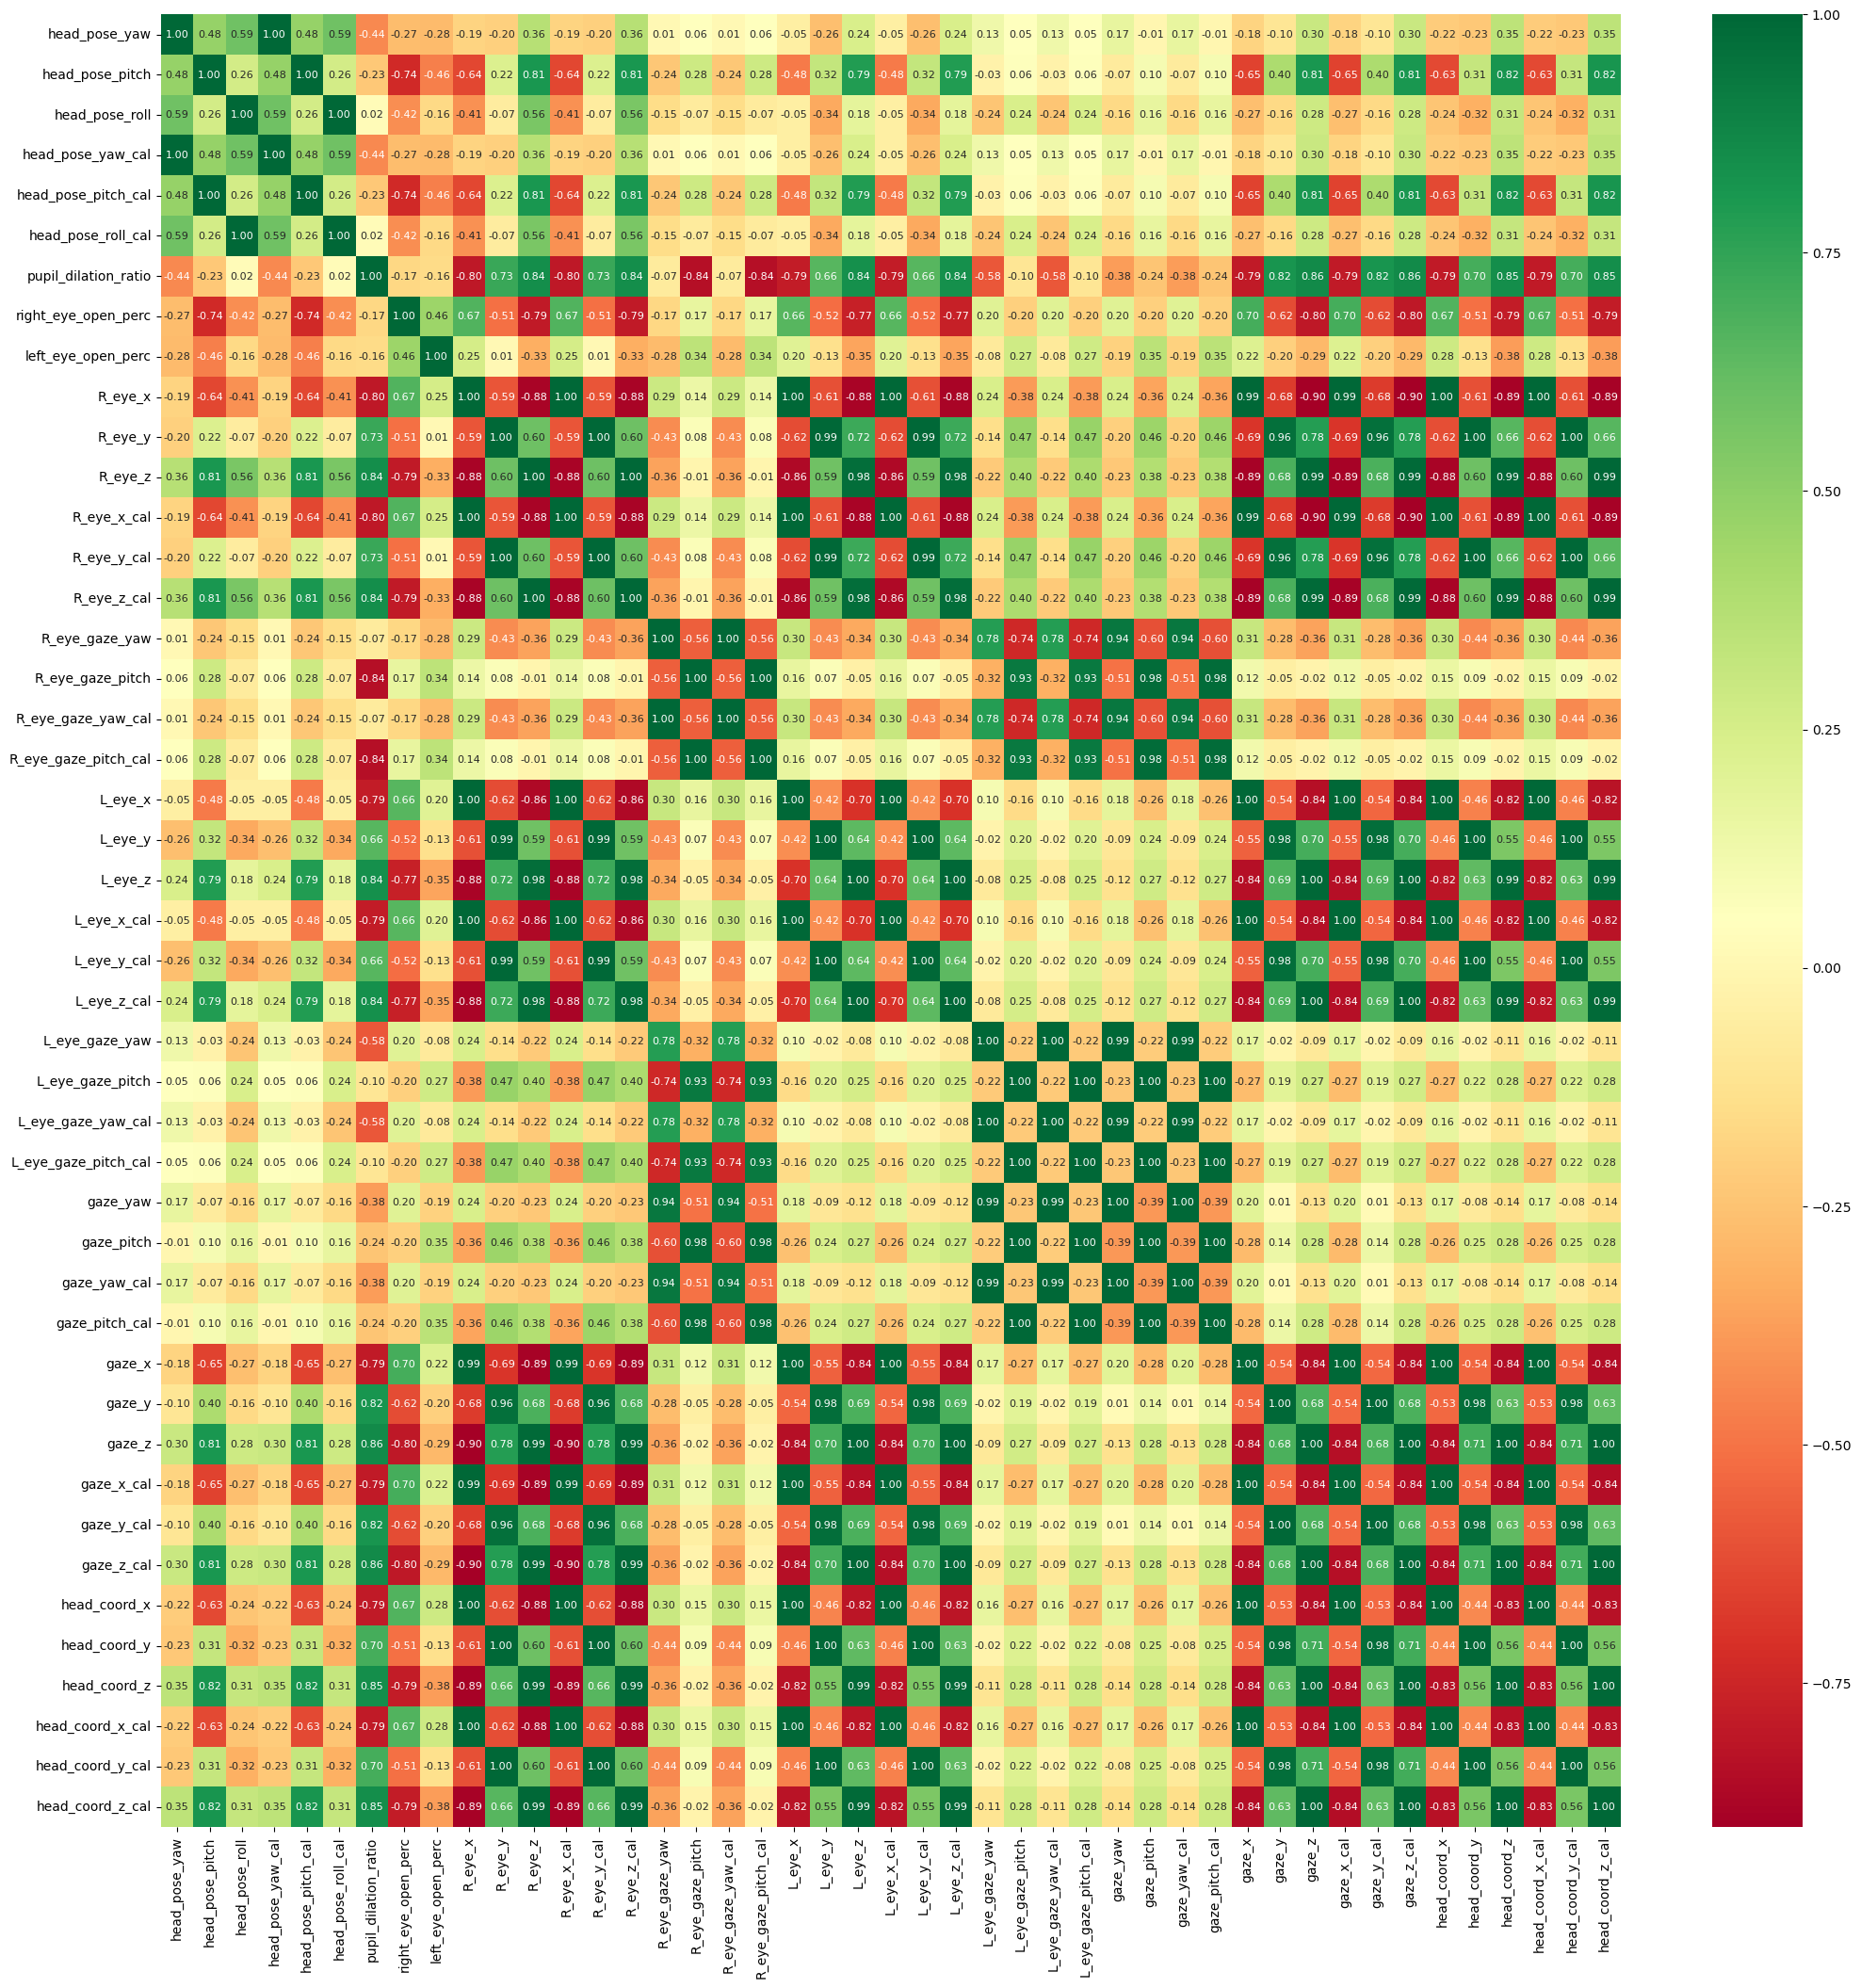

In [44]:
# calculate the corr between each variable
plt.figure(figsize = (25,25))
sns.heatmap(df.loc[:,'head_pose_yaw':'head_coord_z_cal'].corr(), cmap = "RdYlGn", annot = True, annot_kws={"fontsize":8}, fmt=".2f")

In [45]:
cal_list=['head_pose_yaw_cal', 'head_pose_pitch_cal', 'head_pose_roll_cal',
          'R_eye_x_cal', 'R_eye_y_cal', 'R_eye_z_cal', 
          'R_eye_gaze_yaw_cal', 'R_eye_gaze_pitch_cal',
          'L_eye_x_cal', 'L_eye_y_cal', 'L_eye_z_cal',
          'L_eye_gaze_yaw_cal', 'L_eye_gaze_pitch_cal', 
          'gaze_yaw_cal', 'gaze_pitch_cal',
          'gaze_x_cal', 'gaze_y_cal', 'gaze_z_cal',
          'head_coord_x_cal', 'head_coord_y_cal', 'head_coord_z_cal']

In [46]:
# drop the duplicated cols
df.drop(cal_list,axis=1,inplace=True)

In [47]:
df.columns

Index(['frame_number', 'timestamp', 'frame_status', 'camera_status',
       'is_face_valid', 'is_face_human', 'head_pose_yaw', 'head_pose_pitch',
       'head_pose_roll', 'pupil_dilation_ratio', 'right_eye_open_perc',
       'left_eye_open_perc', 'R_eye_x', 'R_eye_y', 'R_eye_z', 'R_eye_gaze_yaw',
       'R_eye_gaze_pitch', 'L_eye_x', 'L_eye_y', 'L_eye_z', 'L_eye_gaze_yaw',
       'L_eye_gaze_pitch', 'gaze_yaw', 'gaze_pitch', 'gaze_x', 'gaze_y',
       'gaze_z', 'head_coord_x', 'head_coord_y', 'head_coord_z', 'drowsy'],
      dtype='object')

In [48]:
# calculate the interval of a frametart=[]
start=[]
for i in range(len(df)):
    if df.frame_number.iloc[i]==1:
        start.append(i)

print(start)
end=start[1:]
end.append(len(df))
print(end)

[0, 1151, 2301, 3452, 4602, 5753, 6903, 8054, 9204, 10355, 11505, 11838, 12988, 14139, 14208, 15359, 15503, 16395, 17545, 18695, 19845, 20996, 22146, 23297, 24447, 25598, 26748, 27899, 29049, 30200, 31350, 32322, 33472, 34106, 35256, 36407, 36803, 37493, 38644, 39794, 40945, 42095, 43246, 44396, 45547, 46697, 47848, 48998, 50149, 51299, 52450, 53600, 53677, 54828, 55068, 56218, 56542, 57692, 58843, 59993, 61144, 62294, 63445, 64595, 65746, 66896, 68047, 69197, 70348, 71498, 72649, 73799, 73819, 74970, 75437, 76587, 77115, 78265, 79416, 80566, 81717, 82867, 84018, 85168, 86319, 87469, 88620, 89770, 90921, 92071, 93222, 93403, 94554, 94682, 95832, 96983, 98133, 99284, 100434, 101585, 102735, 103886, 105036, 106187, 107337, 108488, 109638, 110789, 111939, 112541, 113692, 114842, 115993, 117143, 118294, 119444, 120595, 121745, 122896, 124046, 125197, 126347, 127498, 128648, 129799, 130949, 132100, 133250, 134083, 135233, 136384, 137534, 138685, 139835, 140986, 142136, 143287, 144437, 14558

In [49]:
xyz=['head_pose_yaw', 'head_pose_pitch', 'head_pose_roll',
      'R_eye_x', 'R_eye_y', 'R_eye_z', 
       'R_eye_gaze_yaw', 'R_eye_gaze_pitch',
       'L_eye_x', 'L_eye_y', 'L_eye_z', 
       'L_eye_gaze_yaw', 'L_eye_gaze_pitch',
       'gaze_yaw', 'gaze_pitch', 
       'gaze_x', 'gaze_y', 'gaze_z', 
       'head_coord_x', 'head_coord_y', 'head_coord_z']
pos=['pupil_dilation_ratio', 'right_eye_open_perc', 'left_eye_open_perc','drowsy']
binary=['camera_status', 'is_face_valid','is_face_human']

In [50]:
df_xyz=pd.DataFrame()
for i in range(len(start)):
        temp=df.iloc[start[i]:end[i]]
        a=pd.DataFrame((temp[xyz].max()-temp[xyz].min()))
        df_xyz=pd.concat([df_xyz,a.T])
df_xyz.shape

(226, 21)

In [51]:
df_pos=pd.DataFrame()
for i in range(len(start)):
        temp=df.iloc[start[i]:end[i]]
        a=pd.DataFrame(temp[pos].mean())
        df_pos=pd.concat([df_pos,a.T])
df_pos.shape

(226, 4)

In [52]:
df_dy=pd.concat([df_xyz,df_pos],axis=1)
df_dy.head()

,head_pose_yaw,head_pose_pitch,head_pose_roll,R_eye_x,R_eye_y,R_eye_z,R_eye_gaze_yaw,R_eye_gaze_pitch,L_eye_x,L_eye_y,...,gaze_x,gaze_y,gaze_z,head_coord_x,head_coord_y,head_coord_z,pupil_dilation_ratio,right_eye_open_perc,left_eye_open_perc,drowsy
0,11.403310,9.986840,4.780660,13.88668,1.743008,2.436758,NaN,NaN,15.68114,2.195803,...,15.68114,2.195803,1.794092,15.52115,1.933992,2.101553,NaN,86.220447,92.325480,0.0
0,15.015560,16.084290,9.632180,16.58519,2.859877,3.356610,NaN,NaN,16.51231,4.115696,...,16.51231,4.115696,2.303707,16.67554,3.818850,2.688793,NaN,78.733662,90.220961,0.0
0,44.861361,24.891292,24.166920,14.03392,13.778394,5.484125,15.987364,2.115254,12.67134,14.183901,...,10.13753,17.490695,6.128080,13.35263,13.854589,6.445693,NaN,88.964395,90.814847,0.0
0,5.703850,5.962260,3.774440,5.91677,1.195292,1.317594,1.536020,1.196356,6.07276,1.555501,...,7.70479,5.481610,2.080615,5.99476,1.363408,1.269387,NaN,92.581109,92.409607,0.0
0,12.669640,10.450000,9.408044,6.43446,2.838188,1.961262,NaN,NaN,7.45578,3.993428,...,7.45578,3.993428,1.329498,7.49285,3.472257,1.759300,NaN,91.457005,91.833333,0.0


In [53]:
frame_status=[]
camera_status=[]
is_face_valid=[]
is_face_human=[]
frame_number=[]
duration=[]
for i in range(len(start)):
        temp=df.iloc[start[i]:end[i]]
        frame_status.append(len(temp.loc[temp['frame_status']=='PROCESSED',:])/len(temp))
        camera_status.append(len(temp.loc[temp['camera_status']!='',:])/len(temp))
        is_face_valid.append(len(temp.loc[temp['is_face_valid']==True,:])/len(temp))
        is_face_human.append(len(temp.loc[temp['is_face_human']=='YES',:])/len(temp))
        frame_number.append(temp['frame_number'].count())
        duration.append(temp['timestamp'].max()-temp['timestamp'].min())

In [54]:
df_dy['frame_status']=frame_status
df_dy['camera_status']=camera_status
df_dy['is_face_valid']=is_face_valid
df_dy['is_face_humans']=is_face_human
df_dy['frame_number']=frame_number
df_dy['duration']=duration
df_dy['duration']=df_dy['duration'].dt.total_seconds()

In [55]:
df_dy.reset_index(inplace=True)
df_dy.drop('index',axis=1,inplace=True)
df_dy.head()

,head_pose_yaw,head_pose_pitch,head_pose_roll,R_eye_x,R_eye_y,R_eye_z,R_eye_gaze_yaw,R_eye_gaze_pitch,L_eye_x,L_eye_y,...,pupil_dilation_ratio,right_eye_open_perc,left_eye_open_perc,drowsy,frame_status,camera_status,is_face_valid,is_face_humans,frame_number,duration
0,11.403310,9.986840,4.780660,13.88668,1.743008,2.436758,NaN,NaN,15.68114,2.195803,...,NaN,86.220447,92.325480,0.0,1.0,1.0,0.995656,0.927020,1151,45.77314
1,15.015560,16.084290,9.632180,16.58519,2.859877,3.356610,NaN,NaN,16.51231,4.115696,...,NaN,78.733662,90.220961,0.0,1.0,1.0,0.995652,0.960000,1150,42.09059
2,44.861361,24.891292,24.166920,14.03392,13.778394,5.484125,15.987364,2.115254,12.67134,14.183901,...,NaN,88.964395,90.814847,0.0,1.0,1.0,0.995656,0.959166,1151,47.65576
3,5.703850,5.962260,3.774440,5.91677,1.195292,1.317594,1.536020,1.196356,6.07276,1.555501,...,NaN,92.581109,92.409607,0.0,1.0,1.0,0.995652,0.935652,1150,42.49531
4,12.669640,10.450000,9.408044,6.43446,2.838188,1.961262,NaN,NaN,7.45578,3.993428,...,NaN,91.457005,91.833333,0.0,1.0,1.0,0.995656,0.897480,1151,46.15687


In [56]:
df_dy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   head_pose_yaw         226 non-null    float64
 1   head_pose_pitch       226 non-null    float64
 2   head_pose_roll        226 non-null    float64
 3   R_eye_x               220 non-null    float64
 4   R_eye_y               220 non-null    float64
 5   R_eye_z               220 non-null    float64
 6   R_eye_gaze_yaw        73 non-null     float64
 7   R_eye_gaze_pitch      73 non-null     float64
 8   L_eye_x               226 non-null    float64
 9   L_eye_y               226 non-null    float64
 10  L_eye_z               226 non-null    float64
 11  L_eye_gaze_yaw        226 non-null    float64
 12  L_eye_gaze_pitch      226 non-null    float64
 13  gaze_yaw              226 non-null    float64
 14  gaze_pitch            226 non-null    float64
 15  gaze_x                2

In [57]:
df_dy['drowsy'].value_counts(normalize=True)

1.0    0.597345
0.0    0.402655
Name: drowsy, dtype: float64

In [58]:
print(df_dy['frame_status'].value_counts())
print(df_dy['camera_status'].value_counts())
print(len(df_dy.loc[df_dy['is_face_valid']>0.5,:]))
print(len(df_dy.loc[df_dy['is_face_humans']>0.5,:]))
print(len(df_dy.loc[df_dy['frame_number']>600,:]))
print(len(df_dy.loc[df_dy['duration']>25,:]))

1.0    226
Name: frame_status, dtype: int64
1.0    226
Name: camera_status, dtype: int64
225
219
209
207


In [59]:
df_final=df_dy.loc[(df_dy['is_face_valid']>0.5)&(df_dy['is_face_humans']>0.5),:]

<AxesSubplot:>

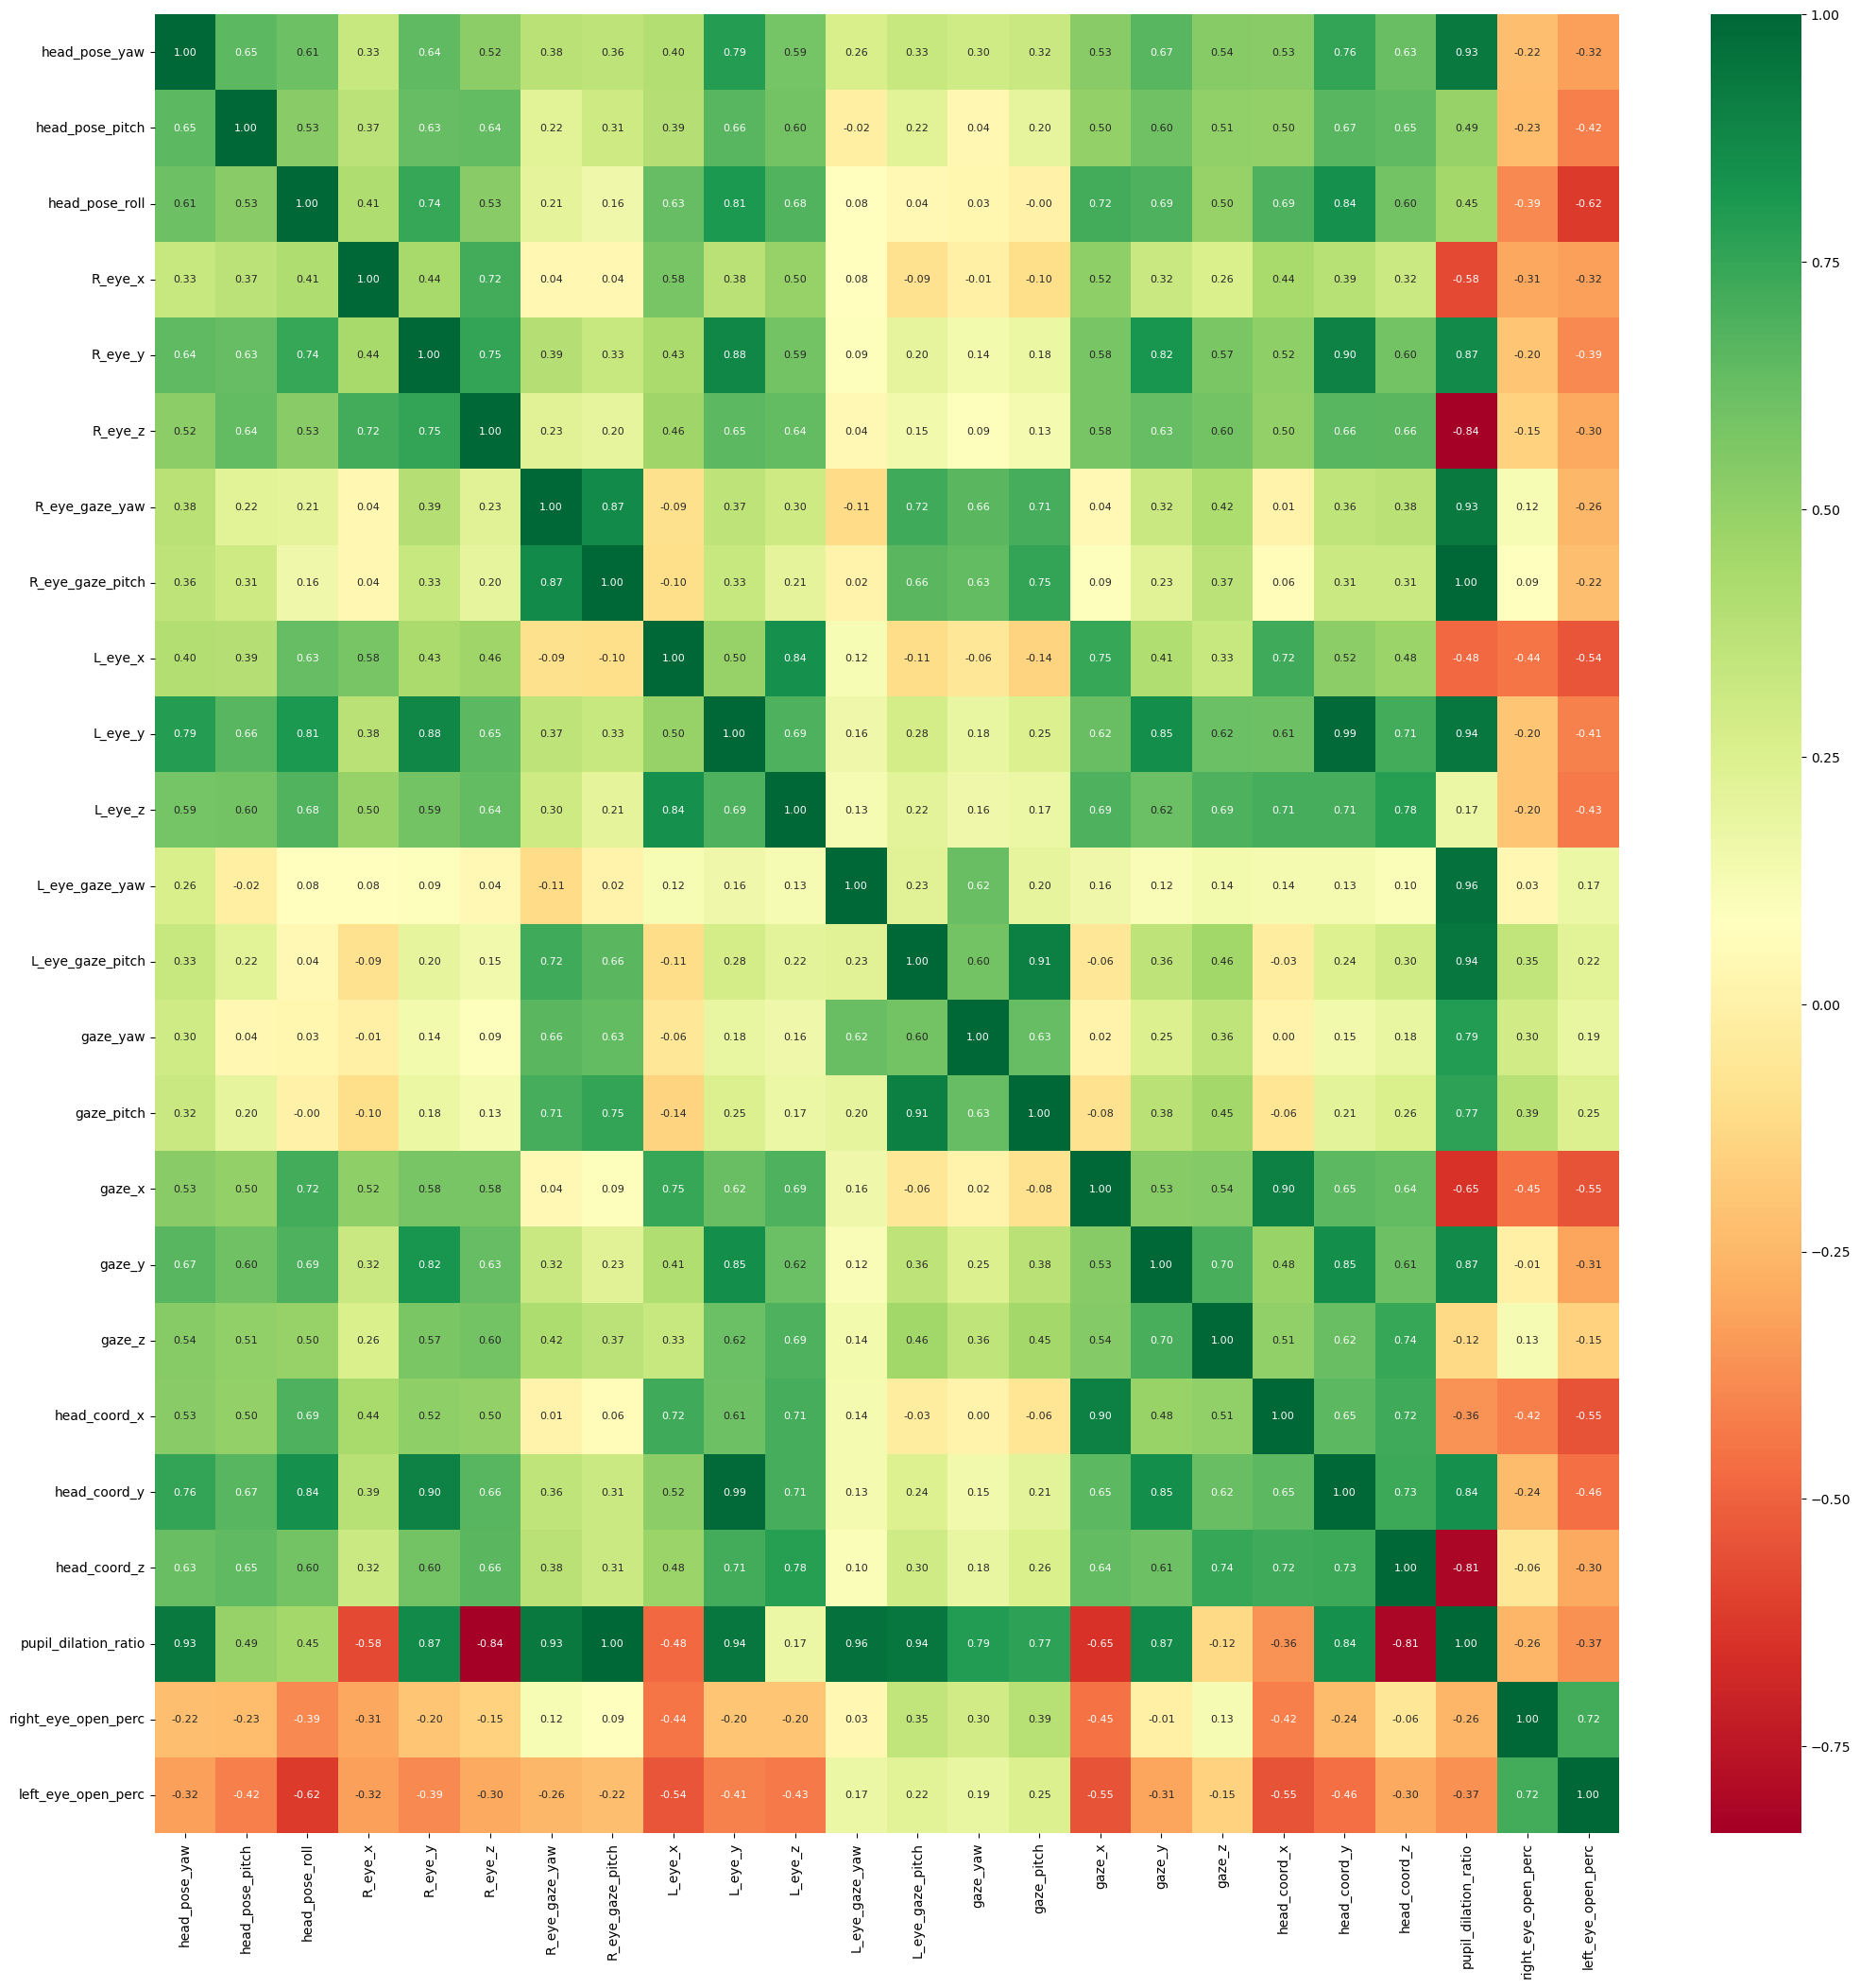

In [61]:
plt.figure(figsize = (25,25))
sns.heatmap(df_final.loc[:,'head_pose_yaw':'left_eye_open_perc'].corr(), cmap = "RdYlGn", annot = True, annot_kws={"fontsize":8}, fmt=".2f")

In [62]:
df_final.drop(['pupil_dilation_ratio'],axis=1,inplace=True)
df_final.drop(['frame_status','camera_status','is_face_valid','is_face_humans','frame_number','duration'],axis=1,inplace=True)
df_final.drop(['R_eye_gaze_yaw','R_eye_gaze_pitch','L_eye_gaze_yaw','L_eye_gaze_pitch',
               'R_eye_x','R_eye_y','R_eye_z','L_eye_x','L_eye_y','L_eye_z'],axis=1,inplace=True)

In [65]:
df_final.isnull().sum().sort_values(ascending=False)

right_eye_open_perc    5
head_pose_yaw          0
head_pose_pitch        0
head_pose_roll         0
gaze_yaw               0
gaze_pitch             0
gaze_x                 0
gaze_y                 0
gaze_z                 0
head_coord_x           0
head_coord_y           0
head_coord_z           0
left_eye_open_perc     0
drowsy                 0
dtype: int64

In [66]:
df_final.dropna(how='any',inplace=True)

# 3. build a baseline model and model validation

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve,auc
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [90]:
train,test = train_test_split(df_final,test_size =0.3 ,random_state = 111)

In [91]:
train_x=train.drop(['drowsy'],axis=1)
test_x=test.drop(['drowsy'],axis=1)
train_y=train['drowsy']
test_y=test['drowsy']

In [92]:
logit  = LogisticRegression(C=1.0, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logit.fit(train_x,train_y)
predictions   = logit.predict(test_x)
probabilities = logit.predict_proba(test_x)

In [93]:
print ("Recall   Score : ",recall_score(test_y,predictions,average='micro'))
print ("Accuracy   Score : ",accuracy_score(test_y,predictions))

Recall   Score 0.9692307692307692
Accuracy   Score :  0.9692307692307692


In [95]:
cm = confusion_matrix(test_y,predictions, normalize='true')
print("Miss Rate:%.3f" %(cm[0][1]/(cm[0][1]+cm[0][0])))

model_roc_auc = roc_auc_score(test_y,predictions) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(test_y,probabilities[:,1])

Miss Rate:0.067
Area under curve :  0.9666666666666667 



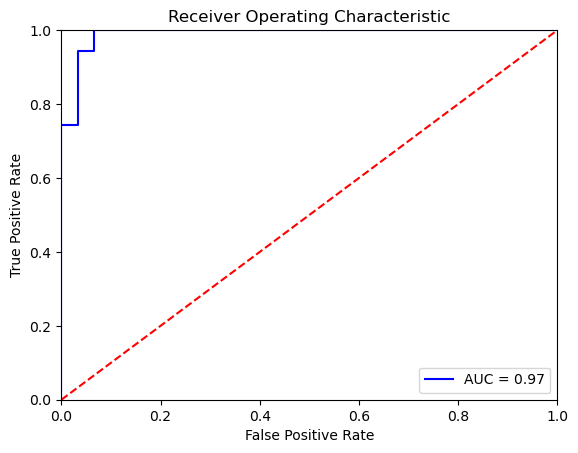

In [96]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 4 build a complicated model and model validation

In [97]:
def search_model(x_train, y_train, est, param_grid, cv):
    model = GridSearchCV(estimator = est, # the estimator/machine learning model
                                     param_grid = param_grid, # parameter grid
                                     scoring = 'f1_weighted', # assign a scoring method 
                                     verbose = 10, # how much text output do we want during the searching process
                                     n_jobs = -1, # the number of process we want to use for the searching job
                                     cv = cv) # number of folds of cross validation
    
    # Fit Grid Search Model
    model.fit(x_train, y_train)   # refit the model to the data
    return model

In [98]:
param_grid = {'n_estimators':[100,300,500]}
RF = search_model(train_x,train_y,RandomForestClassifier(),param_grid,3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [99]:
print("Best score: %0.3f" % RF.best_score_)
print("Best parameters set:", RF.best_params_)
print("Scores:", RF.cv_results_) 

Best score: 0.993
Best parameters set: {'n_estimators': 100}
Scores: {'mean_fit_time': array([0.1763076 , 0.39517275, 0.61393126]), 'std_fit_time': array([0.00627019, 0.00542233, 0.01664311]), 'mean_score_time': array([0.01350045, 0.02626348, 0.0392286 ]), 'std_score_time': array([0.00338737, 0.00187992, 0.00261713]), 'param_n_estimators': masked_array(data=[100, 300, 500],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 300}, {'n_estimators': 500}], 'split0_test_score': array([0.98009248, 0.98009248, 0.98009248]), 'split1_test_score': array([1., 1., 1.]), 'split2_test_score': array([1., 1., 1.]), 'mean_test_score': array([0.99336416, 0.99336416, 0.99336416]), 'std_test_score': array([0.0093845, 0.0093845, 0.0093845]), 'rank_test_score': array([1, 1, 1])}


In [100]:
RFC=RandomForestClassifier(n_estimators = 500)
RFC.fit(train_x,train_y)
predictions_rf   = RFC.predict(test_x)
probabilities_rf = RFC.predict_proba(test_x)

In [101]:
print ("Recall   Score : ",recall_score(test_y,predictions,average='micro'))
print ("Accuracy   Score : ",accuracy_score(test_y,predictions_rf))

Recall   Score 0.9692307692307692
Accuracy   Score :  0.9846153846153847


In [102]:
cm = confusion_matrix(test_y,predictions_rf, normalize='true')
print("Miss Rate:%.3f" %(cm[0][1]/(cm[0][1]+cm[0][0])))

model_roc_auc = roc_auc_score(test_y,predictions_rf) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(test_y,probabilities_rf[:,1])

len(RFC.feature_importances_)

Miss Rate:0.033
Area under curve :  0.9833333333333334 



13

In [103]:
mydict_rf={}
col=df_final.drop('drowsy',axis=1)
for i,key in enumerate(col):
    mydict_rf[key]=mydict_rf.get(key,0)+RFC.feature_importances_[i]
pd_rf=pd.DataFrame.from_dict(mydict_rf, orient='index')
pd_rf.columns=['feature_importance']
pd_rf.nlargest(5,columns='feature_importance')

,feature_importance
right_eye_open_perc,0.344972
left_eye_open_perc,0.272072
head_coord_x,0.080264
gaze_x,0.055702
gaze_pitch,0.047991


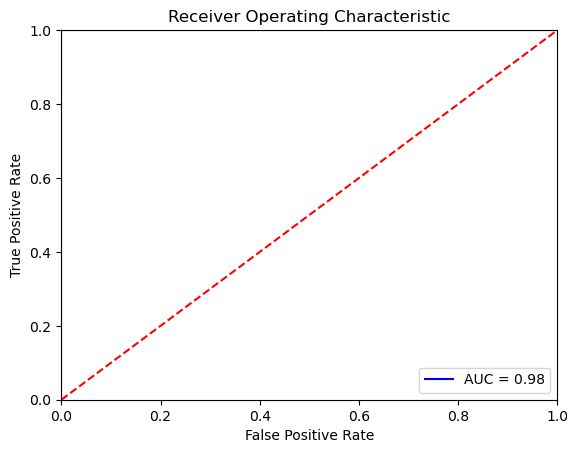

In [104]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % model_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 5. upgrade the model

In [105]:
train_lg,test_lg = train_test_split(df_final[['right_eye_open_perc','left_eye_open_perc','drowsy']] ,test_size =0.3 ,random_state = 111)

In [106]:
train_x=train_lg[['right_eye_open_perc','left_eye_open_perc']]
test_x=test_lg[['right_eye_open_perc','left_eye_open_perc']]
train_y=train_lg['drowsy']
test_y=test_lg['drowsy']

In [107]:
logit  = LogisticRegression(C=1.0, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logit.fit(train_x,train_y)
predictions   = logit.predict(test_x)
probabilities = logit.predict_proba(test_x)

In [108]:
print ("Recall   Score : ",recall_score(test_y,predictions,average='micro'))
print ("Accuracy   Score : ",accuracy_score(test_y,predictions_rf))

Recall   Score 0.9538461538461539
Accuracy   Score :  0.9846153846153847


In [109]:
cm = confusion_matrix(test_y,predictions_rf, normalize='true')
print("Miss Rate:%.3f" %(cm[0][1]/(cm[0][1]+cm[0][0])))

model_roc_auc = roc_auc_score(test_y,predictions_rf) 
print ("Area under curve : ",model_roc_auc,"\n")

Miss Rate:0.033
Area under curve :  0.9833333333333334 

